In [ ]:
! pip install -qU "python-gdcm" pydicom pylibjpeg "opencv-python-headless" wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 19.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os

def mount_and_navigate_to_dir(directory_path="/content/drive/MyDrive/rsna_data/"):
    """
    Mount Google Drive and navigate to a specific directory.

    Args:
    - directory_path (str): The directory to navigate to after mounting.
    """
    ROOT = "/content/drive"
    drive.mount(ROOT, force_remount=True)
    os.chdir(directory_path)
    print(f"Current directory: {os.getcwd()}")

mount_and_navigate_to_dir()

MessageError: ignored

Notebook Color Schemes:


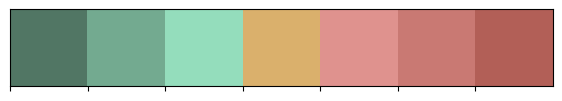

  Preparing metadata (setup.py) ... done


In [ ]:
# General Libraries
import os
import re
import gc
import cv2
import wandb
import random
import math
from glob import glob
from tqdm import tqdm
from pprint import pprint
from time import time
import datetime as dtime
from datetime import datetime
import itertools
import warnings
import pandas as pd
import numpy as np
import pydicom # for DICOM images
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder, normalize

# For the Visuals
import seaborn as sns
import matplotlib as mpl
from matplotlib import cm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Rectangle
from IPython.display import display_html
plt.rcParams.update({'font.size': 16})

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'RSNA_Breast_Cancer', '_wandb_kernel': 'aot'}

# Custom colors
class clr:
    S = '\033[1m' + '\033[91m'
    E = '\033[0m'

my_colors = ["#517664", "#73AA90", "#94DDBC", "#DAB06C",
             "#DF928E", "#C97973", "#B25F57"]
CMAP1 = ListedColormap(my_colors)

print(clr.S+"Notebook Color Schemes:"+clr.E)
sns.palplot(sns.color_palette(my_colors))
plt.show()

!pip install -q efficientnet_pytorch
# PyTorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import FloatTensor, LongTensor
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Data Augmentation for Image Preprocessing
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
                            RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise,
                            Rotate, RandomResizedCrop, Cutout, ShiftScaleRotate, ToGray)
from albumentations.pytorch import ToTensorV2

from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet34, resnet50

# SKlearn
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

import pandas as pd
import numpy as np
import pydicom
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torch.utils.data import DataLoader, Dataset
from albumentations import Compose, RandomResizedCrop, ShiftScaleRotate, HorizontalFlip, VerticalFlip
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import pydicom
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
                            RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise,
                            Rotate, RandomResizedCrop, Cutout, ShiftScaleRotate, ToGray)
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix


In [ ]:
b = pd.read_csv("train.csv")
b.columns


Index(['patient_id', 'bowel_healthy', 'bowel_injury', 'extravasation_healthy',
       'extravasation_injury', 'kidney_healthy', 'kidney_low', 'kidney_high',
       'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy',
       'spleen_low', 'spleen_high', 'any_injury'],
      dtype='object')

In [ ]:
# b['kidney_healthy'].value_counts() # 2965 182
# b['kidney_low'].value_counts() # 3032 115
# b['kidney_high'].value_counts() # 3080 67
b['kidney_value'].value_counts() # 3080 67
# b[(b['kidney_healthy'] == 0) and (b['kidney_low'] == 0) and (b['kidney_high'] ==0)]

0    2965
1     115
2      67
Name: kidney_value, dtype: int64

In [ ]:
def kid_assign_value(row):
    if row['kidney_healthy'] == 1:
        return 0
    elif row['kidney_low'] == 1:
        return 1
    elif row['kidney_high'] == 1:
        return 2
    else:
        return None
def liver_assign_value(row):
    if row['liver_healthy'] == 1:
        return 0
    elif row['liver_low'] == 1:
        return 1
    elif row['liver_high'] == 1:
        return 2
    else:
        return None

def spleen_assign_value(row):
    if row['spleen_healthy'] == 1:
        return 0
    elif row['spleen_low'] == 1:
        return 1
    elif row['spleen_high'] == 1:
        return 2
    else:
        return None

b['kidney_value'] = b.apply(kid_assign_value, axis=1)
# b['liver_value'] = b.apply(liver_assign_value, axis=1)
# b['spleen_value'] = b.apply(spleen_assign_value, axis=1)

      patient_id  bowel_healthy  bowel_injury  extravasation_healthy  \
0          10004              1             0                      0   
1          10005              1             0                      1   
2          10007              1             0                      1   
3          10026              1             0                      1   
4          10051              1             0                      1   
...          ...            ...           ...                    ...   
3142        9951              1             0                      1   
3143        9960              1             0                      1   
3144        9961              1             0                      1   
3145        9980              1             0                      1   
3146        9983              1             0                      1   

      extravasation_injury  kidney_healthy  kidney_low  kidney_high  \
0                        1               0           1          

In [ ]:
a = pd.read_csv("train_dicom_row_data.csv")
# b = pd.read_csv("train.csv")
b = b[['patient_id','kidney_value']]
# b = b[['patient_id','liver_value']]
# b = b[['patient_id','spleen_value']]

# a의 'PatientID'와 b의 'patient_id'를 기준으로 조인
merged_df = pd.merge(a, b, left_on='PatientID', right_on='patient_id', how='inner')
merged_df.drop(columns=["patient_id"], inplace=True)
# dcm path 추가
path = 'train_images/' + merged_df['PatientID'].astype(str) + '/' + merged_df['SeriesNumber'].astype(str)
merged_df['path'] = 'train_images/' + merged_df['PatientID'].astype(str) + '/' + merged_df['SeriesNumber'].astype(str)

# 결과 출력
merged_df

,PatientID,HighBit,PatientPosition,RescaleType,SeriesNumber,aortic_hu,ImageOrientationPatient1,ImageOrientationPatient2,ImageOrientationPatient3,ImageOrientationPatient4,ImageOrientationPatient5,ImageOrientationPatient6,PixelSpacing1,PixelSpacing2,kidney_value,path
0,49954,15,0,0,41479,253.0,1.0,0.0,0.0,0.0,1.0,0.0,0.923000,0.923000,0,train_images/49954/41479
1,50737,11,1,1,59269,100.0,1.0,0.0,0.0,0.0,1.0,0.0,0.753906,0.753906,0,train_images/50737/59269
2,55903,15,1,1,29738,576.0,1.0,-0.0,0.0,-0.0,1.0,0.0,0.753906,0.753906,0,train_images/55903/29738
3,55903,15,1,1,5363,246.0,1.0,-0.0,0.0,-0.0,1.0,0.0,0.753906,0.753906,0,train_images/55903/5363
4,51078,15,0,1,62342,153.0,1.0,0.0,0.0,0.0,1.0,0.0,0.652344,0.652344,0,train_images/51078/62342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4706,14790,15,0,1,7720,282.0,1.0,0.0,0.0,0.0,1.0,0.0,0.859375,0.859375,0,train_images/14790/7720
4707,14790,15,0,1,60494,133.0,1.0,0.0,0.0,0.0,1.0,0.0,0.859375,0.859375,0,train_images/14790/60494
4708,9549,15,0,0,36394,245.0,1.0,0.0,0.0,0.0,1.0,0.0,0.930000,0.930000,1,train_images/9549/36394
4709,9549,15,0,0,20222,132.0,1.0,0.0,0.0,0.0,1.0,0.0,0.907000,0.907000,1,train_images/9549/20222


In [ ]:
import pandas as pd
import numpy as np
import pydicom
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
                            RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise,
                            Rotate, RandomResizedCrop, Cutout, ShiftScaleRotate, ToGray)
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import pandas as pd
import numpy as np
import pydicom
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from albumentations import (Compose, Resize, HorizontalFlip, VerticalFlip, RandomRotate90, ShiftScaleRotate, RandomBrightnessContrast, GaussNoise, Normalize, ToFloat)
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import time
# RSNADataset 클래스 정의
class RSNADataset(Dataset):
    def __init__(self, dataframe, vertical_flip, horizontal_flip, is_train=True):
        self.dataframe, self.is_train = dataframe, is_train
        self.vertical_flip, self.horizontal_flip = vertical_flip, horizontal_flip
        if is_train:
            self.transform = Compose([
                # 이미지 크기 조절
                Resize(height=256, width=256),
                # 좌우 뒤집기 (수평 뒤집기) 및 상하 뒤집기 (수직 뒤집기)
                HorizontalFlip(p=self.horizontal_flip),
                VerticalFlip(p=self.vertical_flip),
                # 랜덤 회전 (90도 단위)
                RandomRotate90(p=0.5),
                # 이미지 이동, 크기 조절 및 회전
                ShiftScaleRotate(rotate_limit=20, scale_limit=0.1, p=0.5),
                # 랜덤한 밝기와 대비 조절
                # RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                # 가우시안 노이즈 추가
                # GaussNoise(p=0.2),
                # 이미지를 실수형으로 변환
                ToFloat(max_value=255.0),
                # 이미지 정규화
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                # 이미지를 PyTorch 텐서로 변환
                ToTensorV2(),
            ])
        else:
            self.transform = Compose([Resize(height=256, width=256), ToTensorV2()])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        folder_path = row['path']
        file_list = sorted(os.listdir(folder_path), key=lambda x: int(x.split('.')[0]))
        image_path1 = folder_path + '/' + file_list[len(file_list)//2-1]
        image_path2 = folder_path + '/' + file_list[len(file_list)//2]
        image_path3 = folder_path + '/' + file_list[len(file_list)//2+1]
        image1 = pydicom.dcmread(image_path1).pixel_array.astype(np.float32)
        image2 = pydicom.dcmread(image_path2).pixel_array.astype(np.float32)
        image3 = pydicom.dcmread(image_path3).pixel_array.astype(np.float32)
        combined_image = np.stack([image1, image2, image3], axis=-1)

        csv_data = np.array(row[['HighBit', 'PatientPosition', 'RescaleType', 'aortic_hu', 'ImageOrientationPatient1', 'ImageOrientationPatient2', 'ImageOrientationPatient3',
                                'ImageOrientationPatient4', 'ImageOrientationPatient5', 'ImageOrientationPatient6', 'PixelSpacing1', 'PixelSpacing2']].values, dtype=np.float32)

        transf_image = self.transform(image=combined_image)['image']

        return {"image": transf_image, "meta": csv_data, "target": row['kidney_value']}

# 모델 클래스 정의
class ResNet50Network(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        self.features = resnet50(pretrained=True)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 500),
                                 nn.BatchNorm1d(500),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        self.classification = nn.Linear(1000 + 500, output_size)

    def forward(self, image, meta):
        image = self.features(image)
        meta = self.csv(meta)
        image_meta_data = torch.cat((image, meta), dim=1)
        out = self.classification(image_meta_data)
        return out

In [ ]:
start = time.time

In [ ]:
vertical_flip = 0.5
horizontal_flip = 0.5
output_size = 3

start = time.time()
# selected_df = merged_df.iloc[:100]
selected_df = merged_df

# 테스트 데이터셋 및 DataLoader 생성
value_0 = selected_df[selected_df['kidney_value'] == 0]
value_1 = selected_df[selected_df['kidney_value'] == 1]
value_2 = selected_df[selected_df['kidney_value'] == 2]

num_samples = min(len(value_0), len(value_1), len(value_2))
sampled_0 = value_0.sample(n=num_samples, random_state=1234)
sampled_1 = value_1.sample(n=num_samples, random_state=1234)
sampled_2 = value_2.sample(n=num_samples, random_state=1234)
same_num_df = pd.concat([sampled_0, sampled_1, sampled_2], axis=0)

train_data, valid_data = train_test_split(same_num_df, stratify=same_num_df['kidney_value'], test_size=0.2, shuffle=True, random_state=1234)  # stratify based on 'kidney_value'

# train_data, valid_data = train_test_split(same_num_df, stratify=same_num_df['kidney_value'], test_size=0.2, shuffle=True, random_state=1234)
train_data = RSNADataset(train_data, vertical_flip, horizontal_flip, is_train=True)
valid_data = RSNADataset(valid_data, vertical_flip, horizontal_flip,is_train=False)
train_loader = DataLoader(train_data, batch_size=30, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_data, batch_size=30, shuffle=False, num_workers=2)

# Device 설정 및 모델 초기화
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
no_columns = len(selected_df.columns) - 4
output_size = 1
model = ResNet50Network(output_size=output_size, no_columns=no_columns).to(DEVICE)

# 하이퍼파라미터 설정
learning_rate = 0.001
num_epochs = 20

# Criterion 및 optimizer 설정
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# criterion = nn.BCEWithLogitsLoss()
criterion = nn.CrossEntropyLoss()

# 손실 기록을 저장할 리스트 초기화
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

first_batch = next(iter(train_loader))
end = time.time()

print(end-start)
# 첫 번째 배치에서 이미지 데이터 가져오기
images = first_batch['image']

# 채널 수 (3개의 연속된 DICOM 이미지이므로 채널 수는 3입니다)
num_channels = 3
for i in range(images.shape[0]):
    fig, axs = plt.subplots(1, num_channels, figsize=(15, 5))
    for c in range(num_channels):
        # 각 채널을 개별적으로 플로팅
        axs[c].imshow(images[i, c, :, :].cpu().numpy(), cmap='gray')
        axs[c].axis('off')
        axs[c].set_title(f'Channel {c + 1}')
    plt.show()

# 에포크 수만큼 훈련
for epoch in range(num_epochs):
    model.train()  # 모델을 훈련 모드로 설정
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    # for k, data in tqdm(enumerate(itertools.islice(train_loader, 10))):
    for k, data in tqdm(enumerate(train_loader)):
        # 데이터 로드
        image, meta, targets = data['image'].to(DEVICE), data['meta'].to(DEVICE), data['target'].to(DEVICE)

        # 그래디언트 초기화
        optimizer.zero_grad()

        # 순전파
        outputs = model(image, meta)

        # 손실 계산
        loss = criterion(outputs.squeeze(), targets.float())

        # 역전파
        loss.backward()

        # 옵티마이저 단계
        optimizer.step()

        running_loss += loss.item() * image.size(0)

        predicted = torch.round(torch.sigmoid(outputs.squeeze()))  # 시그모이드 함수를 적용하여 예측값을 0 또는 1로 바꿉니다.
        #print(predicted)
        #print(targets)
        #print((predicted == targets).sum().item())
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    #모델 저장
    if(epoch%50 == 49):
      checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
      }
      print("=> Saving checkpoint")
      torch.save(checkpoint, f"checkpoint/resnet50_ydlee_test{epoch}.pth")

    test_loss = 0.0
    correct_test = 0
    total_test = 0
    model.eval()
    with torch.no_grad():
        for k, data in enumerate(valid_loader):
            image, meta, targets = data['image'].to(DEVICE), data['meta'].to(DEVICE), data['target'].to(DEVICE)
            outputs = model(image, meta)
            loss = criterion(outputs.squeeze(), targets.float())
            test_loss += loss.item()

            predicted = torch.round(torch.sigmoid(outputs.squeeze()))
            print(predicted)
            #print(targets)
            #print((predicted == targets).sum().item())
            correct_test += (predicted == targets).sum().item()
            total_test += targets.size(0)

    epoch_loss = test_loss / len(valid_loader.dataset)
    test_losses.append(epoch_loss)
    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch + 1}/{num_epochs}, Test Loss: {epoch_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

Output hidden; open in https://colab.research.google.com to view.

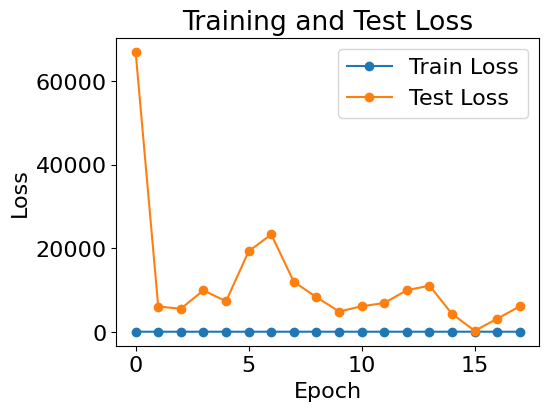

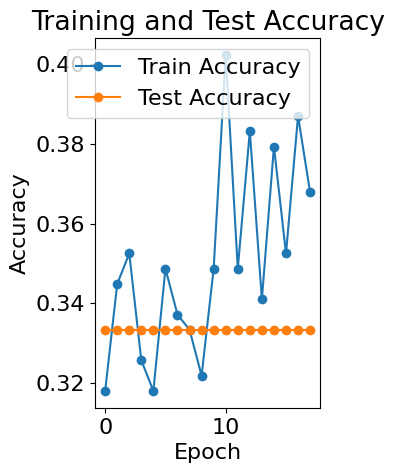

In [ ]:
# 손실 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(train_losses[2:], '-o', label='Train Loss')
plt.plot(test_losses[2:], '-o', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# 정확도 시각화
plt.subplot(1, 2, 2)
plt.plot(train_accuracies[2:], '-o', label='Train Accuracy')
plt.plot(test_accuracies[2:], '-o', label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

Shape of the weights: (64, 3, 7, 7)


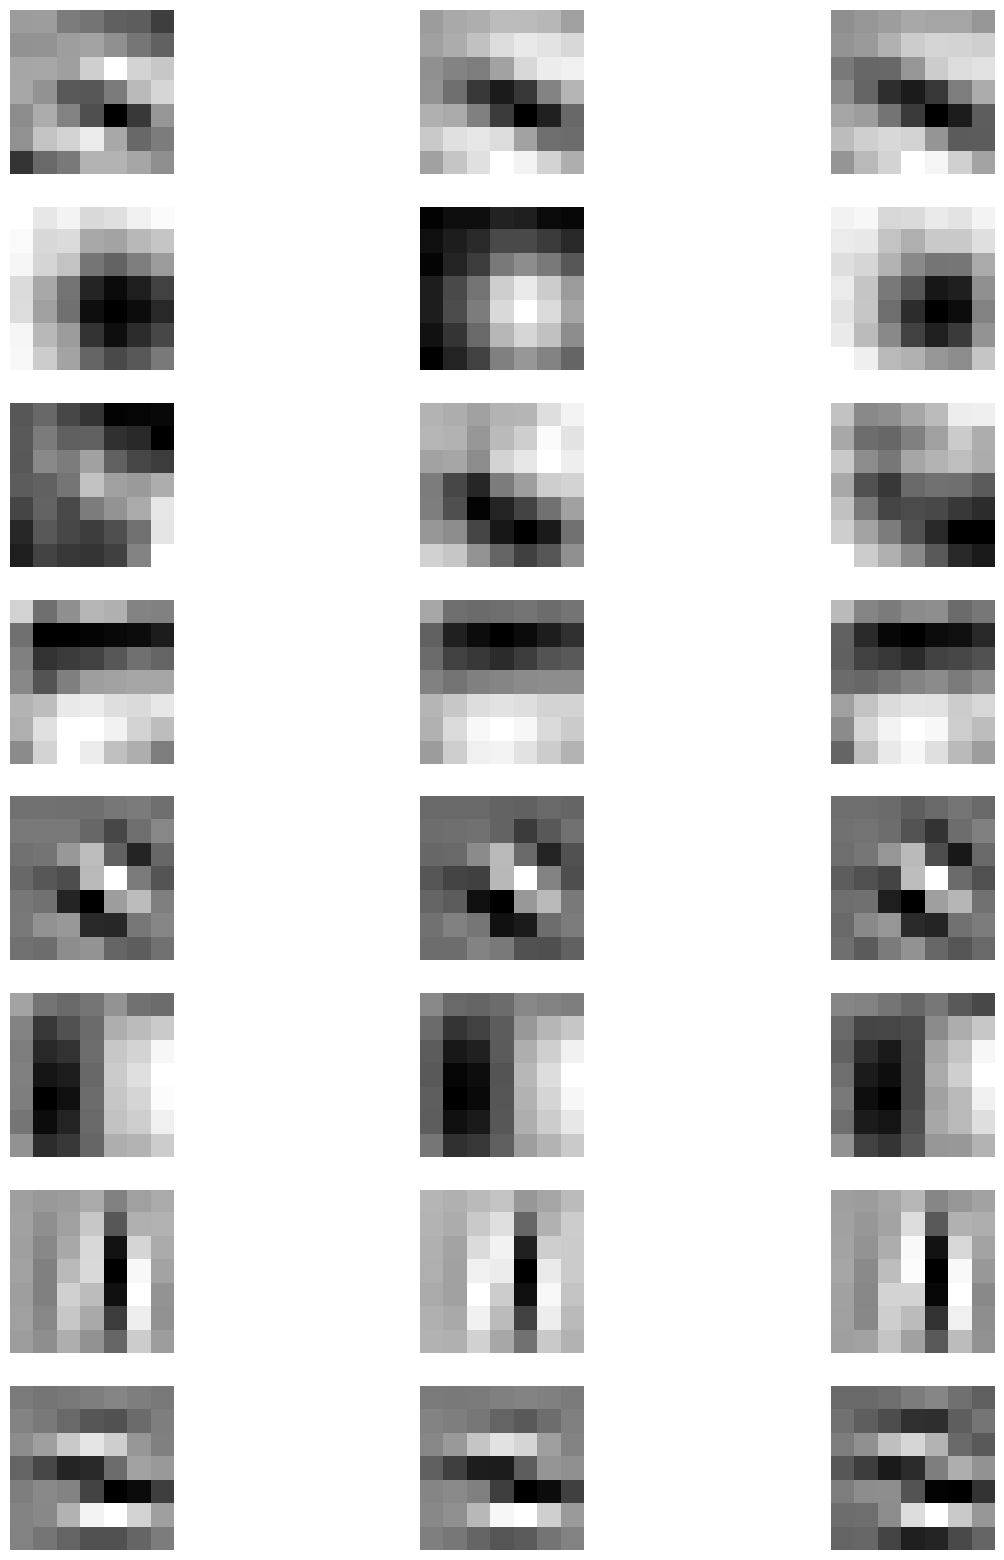

In [ ]:
import matplotlib.pyplot as plt

# 모델의 pretrained 가중치 로드
model = resnet50(pretrained=True)

# 첫 번째 Convolutional Layer의 가중치 가져오기
weights = model.conv1.weight.data.cpu().numpy()

# 가중치의 shape 확인 (64, 3, 7, 7) -> 64개의 3채널 7x7 필터
print("Shape of the weights:", weights.shape)

# 처음 8개의 필터만 시각화
# n_filters_to_show = weights.shape[0]
n_filters_to_show = 8
fig, axs = plt.subplots(n_filters_to_show, 3, figsize=(15, 20))

for i in range(n_filters_to_show):
    for j in range(3):  # 3 RGB 채널
        axs[i, j].imshow(weights[i, j, :, :], cmap='gray')
        axs[i, j].axis('off')

plt.show()


In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import pydicom
import torch
import torch.nn as nn
from torchvision.models import resnet50
from torch.utils.data import DataLoader, Dataset
from albumentations import Compose, RandomResizedCrop, ShiftScaleRotate, HorizontalFlip, VerticalFlip
import matplotlib.pyplot as plt
import timm

# RSNADataset 클래스 정의
class RSNADataset(Dataset):
    def __init__(self, dataframe, vertical_flip, horizontal_flip, is_train=True):
        self.dataframe, self.is_train = dataframe, is_train
        self.vertical_flip, self.horizontal_flip = vertical_flip, horizontal_flip
        if is_train:
            self.transform = Compose([
                # 이미지 크기 조절
                Resize(height=256, width=256),
                # 좌우 뒤집기 (수평 뒤집기) 및 상하 뒤집기 (수직 뒤집기)
                HorizontalFlip(p=self.horizontal_flip),
                VerticalFlip(p=self.vertical_flip),
                # 랜덤 회전 (90도 단위)
                RandomRotate90(p=0.5),
                # 이미지 이동, 크기 조절 및 회전
                ShiftScaleRotate(rotate_limit=20, scale_limit=0.1, p=0.5),
                # 랜덤한 밝기와 대비 조절
                RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
                # 가우시안 노이즈 추가
                GaussNoise(p=0.2),
                # 이미지를 실수형으로 변환
                ToFloat(max_value=255.0),
                # 이미지 정규화
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                # 이미지를 PyTorch 텐서로 변환
                ToTensorV2(),
            ])
        else:
            self.transform = Compose([Resize(height=256, width=256), ToTensorV2()])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        folder_path = row['path']
        file_list = sorted(os.listdir(folder_path), key=lambda x: int(x.split('.')[0]))
        image_path1 = folder_path + '/' + file_list[len(file_list)//2-1]
        image_path2 = folder_path + '/' + file_list[len(file_list)//2]
        image_path3 = folder_path + '/' + file_list[len(file_list)//2+1]
        image1 = pydicom.dcmread(image_path1).pixel_array.astype(np.float32)
        image2 = pydicom.dcmread(image_path2).pixel_array.astype(np.float32)
        image3 = pydicom.dcmread(image_path3).pixel_array.astype(np.float32)
        csv_data = np.array(row[['HighBit', 'PatientPosition', 'RescaleType', 'aortic_hu', 'ImageOrientationPatient1', 'ImageOrientationPatient2', 'ImageOrientationPatient3',
                                'ImageOrientationPatient4', 'ImageOrientationPatient5', 'ImageOrientationPatient6', 'PixelSpacing1', 'PixelSpacing2']].values, dtype=np.float32)
        transf_image1 = self.transform(image=image1)['image']
        transf_image2 = self.transform(image=image2)['image']
        transf_image3 = self.transform(image=image3)['image']
        transf_image = np.concatenate([transf_image1, transf_image2, transf_image3], axis=0)
        # transf_image = np.concatenate([transf_image1, transf_image2, transf_image3], axis=0)

        return {"image": transf_image, "meta": csv_data, "target": row['any_injury']}


class EfficientNetNetwork(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        self.features = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.features.children())[:-1])  # 마지막 FC 레이어 제거
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 500),
                                 nn.BatchNorm1d(500),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        self.classification = nn.Linear(1280 + 500, output_size)  # efficientnet_b0의 feature 크기는 1280

    def forward(self, image, meta):
        image = self.features(image)
        image = image.squeeze(-1).squeeze(-1)  # Global Average Pooling 이후 차원 축소
        meta = self.csv(meta)
        image_meta_data = torch.cat((image, meta), dim=1)
        out = self.classification(image_meta_data)
        return out


In [ ]:
vertical_flip = 0.5
horizontal_flip = 0.5
output_size = 1

selected_df = merged_df.iloc[:100]

# 테스트 데이터셋 및 DataLoader 생성
negative = selected_df[selected_df['any_injury'] == 0]
positive = selected_df[selected_df['any_injury'] == 1]

num_samples = min(len(negative), len(positive))
negative_samples = negative.sample(n=num_samples, random_state=1234)
positive_samples = positive.sample(n=num_samples, random_state=1234)
same_num_df = pd.concat([negative_samples, positive_samples], axis=0)

train_data, valid_data = train_test_split(same_num_df, stratify=same_num_df['any_injury'], test_size=0.2, shuffle=True, random_state=1234)
train_data = RSNADataset(train_data, vertical_flip, horizontal_flip, is_train=True)
valid_data = RSNADataset(valid_data, vertical_flip, horizontal_flip,is_train=False)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_data, batch_size=4, shuffle=False, num_workers=2)

# Device 설정 및 모델 초기화
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
no_columns = len(selected_df.columns) - 4
output_size = 1
model = EfficientNetNetwork(output_size=output_size, no_columns=no_columns).to(DEVICE)

# 하이퍼파라미터 설정
learning_rate = 0.001
num_epochs = 20

# Criterion 및 optimizer 설정
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss()

# 손실 기록을 저장할 리스트 초기화
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

first_batch = next(iter(train_loader))

# 첫 번째 배치에서 이미지 데이터 가져오기
images = first_batch['image']

# 채널 수 (3개의 연속된 DICOM 이미지이므로 채널 수는 3입니다)
num_channels = 3
for i in range(images.shape[0]):
    fig, axs = plt.subplots(1, num_channels, figsize=(15, 5))
    for c in range(num_channels):
        # 각 채널을 개별적으로 플로팅
        axs[c].imshow(images[i, c, :, :].cpu().numpy(), cmap='gray')
        axs[c].axis('off')
        axs[c].set_title(f'Channel {c + 1}')
    plt.show()

# 에포크 수만큼 훈련
for epoch in range(num_epochs):
    model.train()  # 모델을 훈련 모드로 설정
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for k, data in tqdm(enumerate(train_loader)):
        # 데이터 로드
        image, meta, targets = data['image'].to(DEVICE), data['meta'].to(DEVICE), data['target'].to(DEVICE)

        # 그래디언트 초기화
        optimizer.zero_grad()

        # 순전파
        outputs = model(image, meta)

        # 손실 계산
        loss = criterion(outputs.squeeze(), targets.float())

        # 역전파
        loss.backward()

        # 옵티마이저 단계
        optimizer.step()

        running_loss += loss.item() * image.size(0)

        predicted = torch.round(torch.sigmoid(outputs.squeeze()))  # 시그모이드 함수를 적용하여 예측값을 0 또는 1로 바꿉니다.
        print(predicted)
        #print(targets)
        #print((predicted == targets).sum().item())
        correct_train += (predicted == targets).sum().item()
        total_train += targets.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')

    test_loss = 0.0
    correct_test = 0
    total_test = 0
    model.eval()
    with torch.no_grad():
        for k, data in enumerate(valid_loader):
            image, meta, targets = data['image'].to(DEVICE), data['meta'].to(DEVICE), data['target'].to(DEVICE)
            outputs = model(image, meta)
            loss = criterion(outputs.squeeze(), targets.float())
            test_loss += loss.item()

            predicted = torch.round(torch.sigmoid(outputs.squeeze()))
            print(predicted)
            #print(targets)
            #print((predicted == targets).sum().item())
            correct_test += (predicted == targets).sum().item()
            total_test += targets.size(0)

    epoch_loss = test_loss / len(valid_loader.dataset)
    test_losses.append(epoch_loss)
    test_accuracy = correct_test / total_test
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch + 1}/{num_epochs}, Test Loss: {epoch_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

ValueError: ignored